In [23]:
#libraries
from scipy.signal import butter, filtfilt, spectrogram
import scipy.signal as sis
import scipy.stats as ss
import pandas as pd
import numpy as np

from Participants import Participants

In [24]:
# %matplotlib qt # uncomment for plots in separate window

#### Loading dataset

In [25]:
participant = Participants("data\\participants")

In [26]:
signal = participant[0][0][0]
signal.shape

(299900,)

#### EEG rhythms:
$\alpha = 8-13 \text{Hz}, \ \ \beta = 13-30 \text{Hz},  \ \ \delta = 0.5-4 \text{Hz},  \ \ \theta = 4-8 \text{Hz},  \ \ \gamma = 30-60 \text{Hz}$ 

In [27]:
def bandpass_filter(signal, low_cutoff, high_cutoff, sample_rate, order=5):
    nyquist_freq = 0.5 * sample_rate
    low = low_cutoff / nyquist_freq
    high = high_cutoff / nyquist_freq
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [28]:
fs = 500
N = len(signal) 
time = np.arange(N) / fs

In [29]:
alpha_rhythm = bandpass_filter(signal, 8, 13, fs)
beta_rhythm = bandpass_filter(signal, 13, 30, fs)
delta_rhythm = bandpass_filter(signal, 0.5, 4, fs)
theta_rhythm = bandpass_filter(signal, 4, 8, fs)
gamma_rhythm = bandpass_filter(signal, 30, 60, fs)

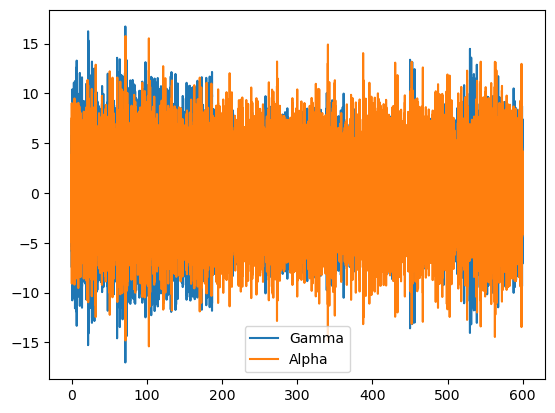

In [30]:
from matplotlib import pyplot as plt

plt.figure(1)
plt.plot(time, gamma_rhythm, label='Gamma')
plt.plot(time, alpha_rhythm, label='Alpha')
plt.legend()

In [31]:
def plot_spect(data, N, fs):
    freq_data = 2 * (np.fft.fft(data) / N)[:N//2+1]
    freqs = np.fft.fftfreq(N, 1/fs)[:N//2+1]
    plt.plot(freqs, np.abs(freq_data))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('One-Sided Spectrum')
    plt.xlim([0, 45])
    plt.show()

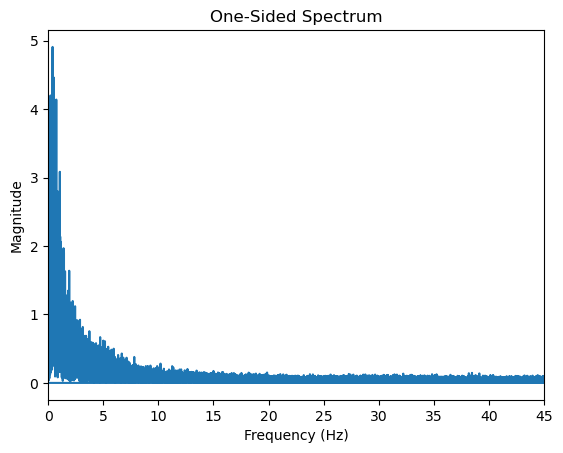

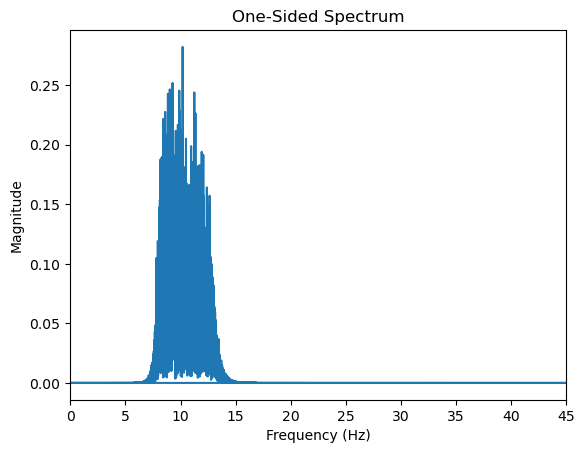

In [32]:
plot_spect(signal, N, fs)
plot_spect(alpha_rhythm, N, fs)

#### Comparing basic features between subjects

In [33]:
n_channels = participant[0][0].shape[0]
n_participants = len(participant.name)

In [34]:
sub1, sub2 = 19, 41
signal0 = participant[sub1][0][0]
signal1 = participant[sub2][0][0]
print("MMSE score of first subject is {} and of second {}".format(participant[sub1][4], participant[sub2][4]))

MMSE score of first subject is 4 and of second 30


### Comparing amplitudes of alpha and theta rhythms

In [46]:
def get_power_band(band, participant_id = -1, channel = -1):
    band_to_freq = {'alpha':[8, 13], 'beta':[13, 30], 'theta':[4, 8]}
    freq = band_to_freq[band]
    print(freq)
    powers = np.empty(n_participants)
    if participant_id == -1 and channel == -1:
        for i in range(n_participants):
            for j in range(n_channels):
                signal = participant[i][0][j]
                signal = bandpass_filter(signal, freq[0], freq[1], fs)
                powers[i] += np.sum(np.square(signal))/len(signal)
            powers[i] /= n_channels
    return powers

In [47]:
band = 'beta'
powers = get_power_band(band)
np.max(powers)

[13, 30]


81.87248703875598

<AxesSubplot:xlabel='power', ylabel='Count'>

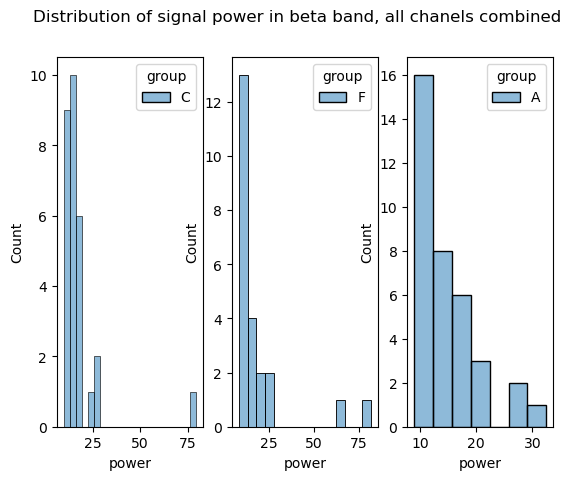

In [48]:
import seaborn as sns

groups = [participant[i][3] for i in range(n_participants)]
data = pd.DataFrame({'power':powers, 'group':groups})
fig, axs = plt.subplots(1, 3)

fig.suptitle("Distribution of signal power in {} band, all chanels combined".format(band))
sns.histplot(ax = axs[0], data=data[data['group']=='C'], x = "power", hue = "group")
# axs[0].set_xlim([0, 80])
# axs[0].set_ylim([0, 15])
sns.histplot(ax = axs[1], data=data[data['group']=='F'], x = "power", hue = "group")
# axs[1].set_xlim([0, 80])
# axs[1].set_ylim([0, 15])
sns.histplot(ax = axs[2], data=data[data['group']=='A'], x = "power", hue = "group")
# axs[2].set_xlim([0, 80])
# axs[2].set_ylim([0, 15])

In [49]:
def get_group_power_data(data, group):
    return np.array(data[data['group']==group]['power'])

In [51]:
group_names = ['A', 'C', 'F']
stds, means = {}, {}
for g in group_names:
    stds[g] = np.std(get_group_power_data(data, g))
    print('std of power in alpha band for group {} is {}'.format(g, np.std(get_group_power_data(data, g))))
for g in group_names:
    means[g] = np.mean(get_group_power_data(data, g))
    print('mean of power in alpha band for group {} is {}'.format(g, np.mean(get_group_power_data(data, g))))

std of power in alpha band for group A is 5.57217647523893
std of power in alpha band for group C is 12.389693900817555
std of power in alpha band for group F is 17.569804093340718
mean of power in alpha band for group A is 14.57065546717299
mean of power in alpha band for group C is 17.59526594653358
mean of power in alpha band for group F is 19.38820708072596


#### Wavelet transform and PSD

In [52]:
import pywt

# first we divide signal in epochs with overlap

epoch_length = 30*fs
overlap_length = int(10*fs)

signal = participant[sub1][0][0]
signal_alpha = bandpass_filter(signal, 8, 13, fs)
signal = signal_alpha
print("Shape of original signal: " + str(signal.shape))
signal_epochs = np.array([signal[i:i+epoch_length] for i in range(0, len(signal)-epoch_length+1, overlap_length)])
print("Shape of signal divided into epochs: " + str(signal_epochs.shape))

Shape of original signal: (434650,)
Shape of signal divided into epochs: (84, 15000)


In [53]:
coeffs = pywt.wavedec(signal_epochs, 'db2', level=5)
cA5, cD5, cD4, cD3, cD2, cD1 = coeffs

In [54]:
import scipy.signal as sis

In [58]:
def plot_psd(signal, band='alpha'):
    if band=='alpha':
        signal = bandpass_filter(signal, 8, 13, fs)
        signal_epochs = np.array([signal[i:i+epoch_length] for i in range(0, len(signal)-epoch_length+1, overlap_length)])
        f, S = sis.periodogram(signal_epochs, fs, scaling='density')
        plt.plot(np.repeat(f, 10, axis=0).reshape(f.shape[0], 10), S[0:10, :].T)
        plt.xlim([8, 13])

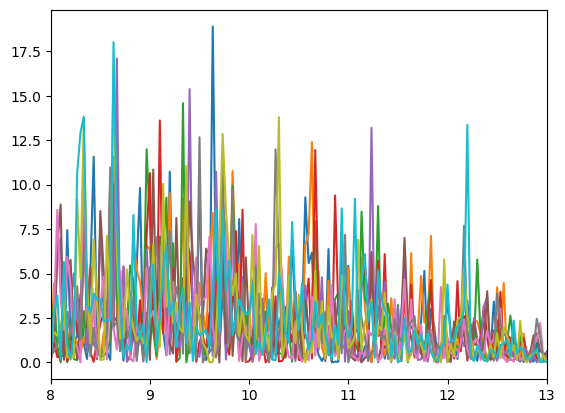

In [60]:
sub1, sub2 = 19, 41

signal = participant[sub1][0][0]
plt.figure(1)
plot_psd(signal)


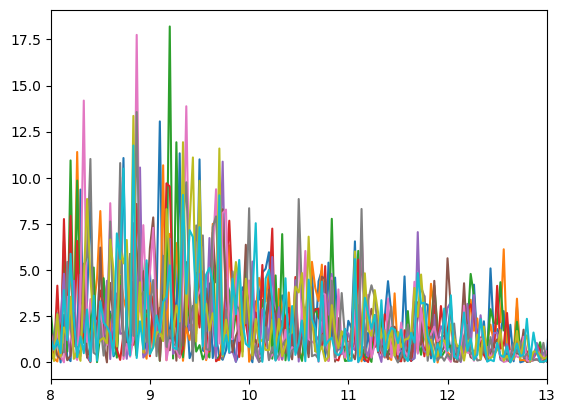

In [61]:
signal = participant[sub2][0][0]
plt.figure(2)
plot_psd(signal)